In [5]:
import os
import json
import torch

import torchvision

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms as T
import numpy as np

from pycocotools.coco import COCO
from PIL import Image, ImageDraw
from coco_utils import get_coco_api_from_dataset
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import fiftyone as fo
import fiftyone.zoo as foz
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision.transforms import functional as F
from torchvision.ops import nms

In [3]:
# Load the checkpoint model
path = r'C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (VGG16)\model'
filename = 'person_detection_model'
full_path = f'{path}\\{filename}-epoch-9.pth'

# Initialize the model and optimizer
backbone = torchvision.models.vgg16(pretrained=False).features
backbone.out_channels = 512
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# Create ROI pooler
roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Number of classes (including background class)
num_classes = 2

# Create Faster R-CNN model
model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load model
checkpoint = torch.load(full_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model and optimizer to the desired device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [82]:
transform = T.ToTensor()
img = transform(ig)

In [83]:
model.eval()
with torch.inference_mode():
    pred = model([img])

In [84]:
pred

[{'boxes': tensor([[ 864.5580,  657.2107,  975.5049,  945.2612],
          [1179.8439,  645.8770, 1399.0277, 1067.0000],
          [ 357.2629,  673.8441,  435.3825,  938.3218],
          [1289.2148,  628.7133, 1394.2493, 1067.0000],
          [ 452.7223,  716.4512,  632.4666, 1043.0513],
          [ 240.3519,  672.4948,  331.0257,  964.2983],
          [1167.5005,  696.2965, 1296.9775, 1067.0000],
          [ 654.9137,  621.6353,  708.9958,  793.2250],
          [ 299.0573,  670.9272, 1477.8257,  983.9591],
          [ 638.1770,  610.9510,  690.3871,  769.3380],
          [ 335.7578,  503.4065,  439.9196,  672.5112],
          [ 233.9897,  684.2177,  451.1597,  958.3514],
          [ 477.9801,  572.3104,  520.8190,  696.1385],
          [ 465.8282,  545.3746,  534.2401,  717.7719],
          [ 356.6963,  488.6969,  399.7855,  635.8252],
          [ 665.1642,  633.6405,  703.5674,  745.9620],
          [1034.2175,  657.5429, 1480.0344, 1049.9341],
          [ 358.2952,  580.2535,  624.7

In [85]:
bboxes, labels, scores = pred[0]['boxes'], pred[0]["labels"], pred[0]["scores"]

In [100]:
scores > 0.7

tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [112]:
(scores > 0.7).sum().item()

7

In [113]:
igg = cv2.imread(r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\orang.jpg")
for i in range((scores > 0.7).sum().item()):
    x1, y1, x2, y2 = bboxes[i].numpy().astype("int")
    confidence = scores[i].item()  # Confidence score for the detection
    igg = cv2.rectangle(igg, (x1, y1), (x2, y2), (0, 255, 0), 5)
    text = f"Confidence: {confidence:.2f}"
    cv2.putText(igg, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)


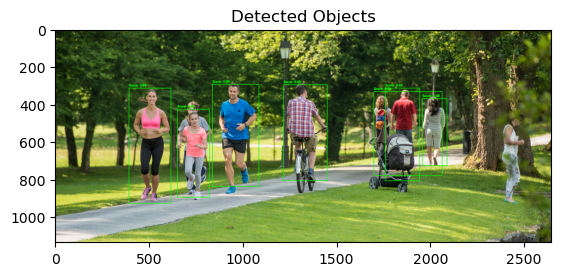

Image with bounding boxes saved at: C:\Users\USER\Documents\2023\AI\2. Person Tracking\detected_objects - vgg16.jpg


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Read the input image
input_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\orang di taman.jpg"
img = cv2.imread(input_path)

# Convert the image to tensor and move to GPU
img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

# Perform prediction on the image
with torch.inference_mode():
    prediction = model(img_tensor)
    
# Move the prediction to CPU for NMS
prediction = [{k: v.cpu() for k, v in pred.items()} for pred in prediction]

# Get the bounding boxes and scores from the prediction
boxes = prediction[0]['boxes']
scores = prediction[0]['scores']

# Set a threshold to filter out weak detections
threshold = 0.8
selected_indices = scores > threshold

# Apply NMS to filter out duplicate detections
filtered_boxes = boxes[selected_indices]
filtered_scores = scores[selected_indices]
nms_indices = nms(filtered_boxes, filtered_scores, iou_threshold=0.7)

# Draw bounding boxes on the image
for idx in nms_indices:
    x1, y1, x2, y2 = filtered_boxes[idx].tolist()
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)  # Convert to integers
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    score = filtered_scores[idx].item()
    cv2.putText(img, f'Score: {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Normalize the pixel values to [0, 1]
img_rgb = img_rgb / 255.0

# Display the image with bounding boxes using Matplotlib
plt.imshow(img_rgb)
plt.title('Detected Objects')
plt.show()

# Save the image in the same folder with bounding boxes
output_path = os.path.join(os.path.dirname(input_path), "detected_objects - vgg16.jpg")
cv2.imwrite(output_path, cv2.cvtColor((img_rgb * 255.0).astype('uint8'), cv2.COLOR_RGB2BGR))
print(f"Image with bounding boxes saved at: {output_path}")

# Epoch 0

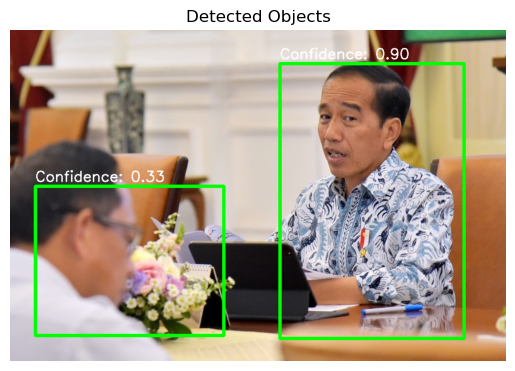

In [30]:
# Convert BGR image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes using Matplotlib
plt.imshow(img_rgb)
plt.title('Detected Objects')
plt.axis('off')
plt.show()

# Epoch 1

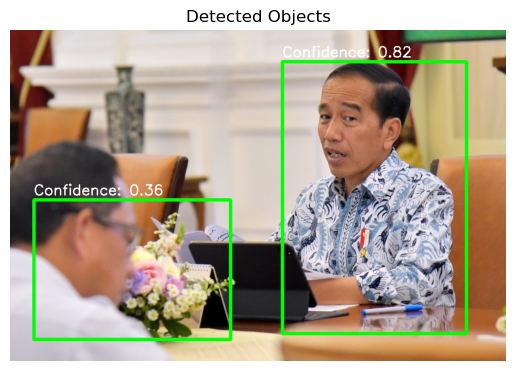

In [39]:
# Convert BGR image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes using Matplotlib
plt.imshow(img_rgb)
plt.title('Detected Objects')
plt.axis('off')
plt.show()

# Epoch 2

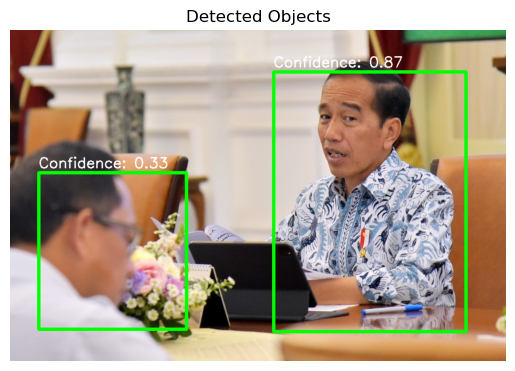

In [49]:
# Convert BGR image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes using Matplotlib
plt.imshow(img_rgb)
plt.title('Detected Objects')
plt.axis('off')
plt.show()

# Epoch 3

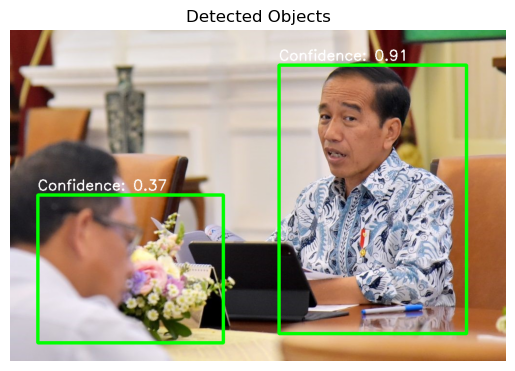

In [59]:
# Convert BGR image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes using Matplotlib
plt.imshow(img_rgb)
plt.title('Detected Objects')
plt.axis('off')
plt.show()

# Epoch 4

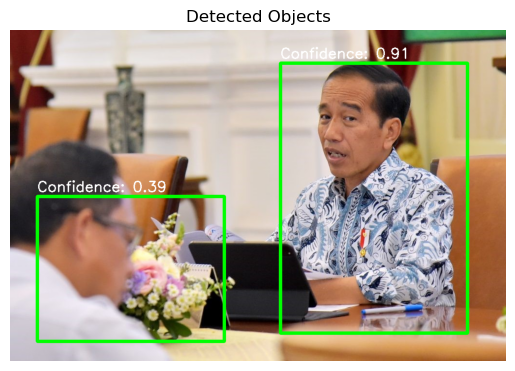

In [69]:
# Convert BGR image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes using Matplotlib
plt.imshow(img_rgb)
plt.title('Detected Objects')
plt.axis('off')
plt.show()

# Epoch 5

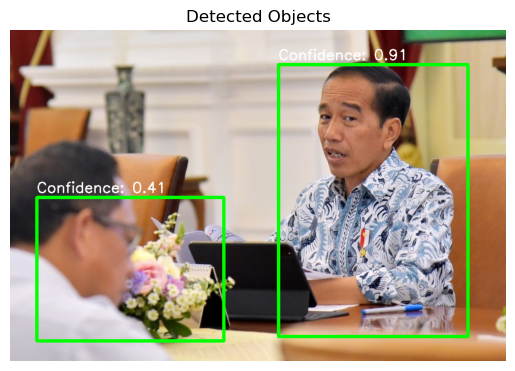

In [79]:
# Convert BGR image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes using Matplotlib
plt.imshow(img_rgb)
plt.title('Detected Objects')
plt.axis('off')
plt.show()

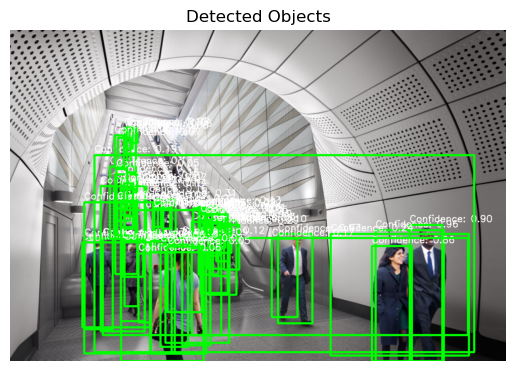

In [93]:
# Convert BGR image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes using Matplotlib
plt.imshow(img_rgb)
plt.title('Detected Objects')
plt.axis('off')
plt.show()

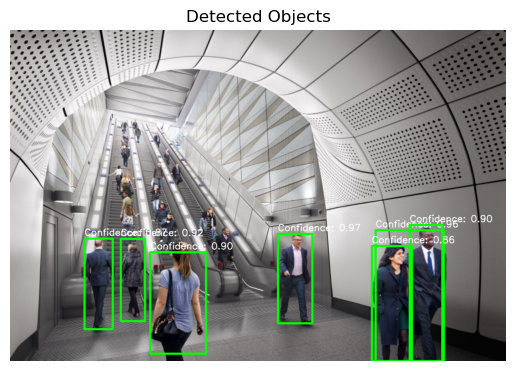

In [114]:
# Convert BGR image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes using Matplotlib
plt.imshow(img_rgb)
plt.title('Detected Objects')
plt.axis('off')
plt.show()

In [ ]:
model.eval()

# Load the video
video_path = 'path/to/your/video.mp4'
video = cv2.VideoCapture(video_path)

# Calculate the frame rate and duration of the video
fps = int(video.get(cv2.CAP_PROP_FPS))
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
duration = total_frames // fps  # duration in seconds

# Calculate the number of frames equivalent to 1 minute
frames_per_minute = fps * 60

# Get the number of frames to read before making predictions
frames_to_read = min(frames_per_minute, total_frames)

# Define the transformation to be applied to each frame
transform = T.Compose([T.ToTensor()])

# Initialize video writer to save the output video
output_path = 'path/to/your/output_video.mp4'
output_fps = fps
output_size = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, output_fps, output_size)

# Loop through the frames in the video
for i in range(frames_to_read):
    ret, frame = video.read()

    if not ret:
        break

    # Preprocess the frame and perform detection
    input_img = transform(frame)
    with torch.no_grad():
        prediction = model([input_img])

    # Extract bounding boxes, labels, and confidence scores from the prediction
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']

    # Loop through the detected objects and draw bounding boxes and text
    for box, label, score in zip(boxes, labels, scores):
        box = [int(coord) for coord in box]
        label = label.item()
        score = score.item()
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        text = f"Label: {label}, Confidence: {score:.2f}"
        cv2.putText(frame, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the frame to the output video
    video_writer.write(frame)

# Release the video and video writer, and close the windows
video.release()
video_writer.release()
cv2.destroyAllWindows()

In [ ]:
# Read the input video
input_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (Resnet)\video\Central Park People Watching.mp4"
cap = cv2.VideoCapture(input_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Create video writer for the output video
output_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (Resnet)\video\output_video.mp4"
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (640, 480))

# Process each frame in the video
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Perform prediction on the frame
    prediction = model([F.to_tensor(frame)])

    # Draw bounding boxes on the frame
    boxes = prediction[0]['boxes'].cpu().detach().numpy()
    scores = prediction[0]['scores'].cpu().detach().numpy()

    for box, score in zip(boxes, scores):
        if score > 0.5:  # threshold for filtering out weak detections
            x1, y1, x2, y2 = map(int, box)
            frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Write the frame to the output video
    video_writer.write(frame)

    frame_count += 1
    if frame_count == fps * 60:  # Stop after 1 minute (60 seconds)
        break

# Release video writer and capture object
video_writer.release()
cap.release()

In [ ]:
# Load the model

model.eval()

# Read the input video
input_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (Resnet)\video\Central Park People Watching.mp4"
cap = cv2.VideoCapture(input_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create video writer for the output video
output_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (Resnet)\video\output_video.mp4"
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Process each frame in the video
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Perform prediction on the frame
    prediction = model([F.to_tensor(frame)])

    # Draw bounding boxes on the frame
    boxes = prediction[0]['boxes'].cpu().detach().numpy()
    scores = prediction[0]['scores'].cpu().detach().numpy()

    for box, score in zip(boxes, scores):
        if score > 0.5:  # threshold for filtering out weak detections
            x1, y1, x2, y2 = map(int, box)
            frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Write the frame to the output video
    video_writer.write(frame)

    frame_count += 1
    if frame_count == fps * 20:  # Stop after 20 seconds
            break

# Release video writer and capture object
video_writer.release()
cap.release()

In [5]:
!pip install jupyter ipywidgets

  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/b8/d4/ce436660098b2f456e2b8fdf76d4f33cbc3766c874c4aa2f772c7a5e943f/ipywidgets-8.1.0-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/121.9 kB ? eta -:--:--
     -------------------------------------- 121.9/121.9 kB 2.4 MB/s eta 0:00:00
  Obtaining dependency information for comm>=0.1.3 from https://files.pythonhosted.org/packages/fe/47/0133ac1b7dc476ed77710715e98077119b3d9bae56b13f6f9055e7da1c53/comm-0.1.4-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.7 from https://files.pythonhosted.org/packages/8e/d4/d31b12ac0b87e8cc9fdb6ea1eb6596de405eaaa2f25606aaa755d0eebbc0/widgetsnbextension-4.0.8-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.7 from https://files.pythonhosted.org/packages/74/5e/2475ac62faf2e342b2bf20b8d8e375f49400ecb38f52e4e0a7557eb1cedb/jupyterlab_widgets-3.0.8-py3-none-any

In [6]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
import torch
import torchvision.transforms.functional as F

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Read the input video
input_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (Resnet)\video\Central Park People Watching.mp4"
cap = cv2.VideoCapture(input_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create video writer for the output video
output_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (Resnet)\video\output_video.mp4"
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Process each frame in the video using tqdm to visualize progress
with tqdm(total=total_frames) as pbar:
    for _ in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # Move the frame to GPU
        frame_tensor = F.to_tensor(frame).unsqueeze(0).to(device)

        # Perform prediction on the frame
        with torch.no_grad():
            prediction = model(frame_tensor)

        # Move the prediction to CPU for further processing
        prediction = [{k: v.cpu() for k, v in pred.items()} for pred in prediction]

        # Draw bounding boxes on the frame
        boxes = prediction[0]['boxes'].numpy()
        scores = prediction[0]['scores'].numpy()

        for box, score in zip(boxes, scores):
            if score > 0.5:  # threshold for filtering out weak detections
                x1, y1, x2, y2 = map(int, box)
                frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Write the frame to the output video
        video_writer.write(frame)
        pbar.update(1)
        
#         frame_count += 1
#         if frame_count == fps * 20:  # Stop after 20 seconds
#             break

# Release video writer and capture object
video_writer.release()
cap.release()


  0%|          | 0/17865 [00:00<?, ?it/s]

C:\Users\USER\anaconda3\envs\object_detection\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
import torch
import torchvision.transforms.functional as F
from torchvision.ops import nms

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Read the input video
input_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (Resnet)\video\Presiden Jokowi Kunjungi Pasar Parungkuda, Sukabumi, 4 Agustus 2023.mp4"
# input_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (Resnet)\video\Central Park People Watching.mp4"
cap = cv2.VideoCapture(input_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create video writer for the output video
output_path = r"C:\Users\USER\Documents\2023\AI\2. Person Tracking\V1 (Resnet)\video\output_video_presiden2.mp4"
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

frame_count = 0
# Process each frame in the video using tqdm to visualize progress
with tqdm(total=total_frames) as pbar:
    for _ in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # Move the frame to GPU
        frame_tensor = F.to_tensor(frame).unsqueeze(0).to(device)

        # Perform prediction on the frame
        with torch.no_grad():
            prediction = model(frame_tensor)

        # Move the prediction to CPU for further processing
        prediction = [{k: v.cpu() for k, v in pred.items()} for pred in prediction]

        # Obtain the boxes, scores, and labels from the prediction
        boxes = prediction[0]['boxes']
        scores = prediction[0]['scores']

        # Apply NMS to filter out redundant detections
        keep = nms(boxes, scores, iou_threshold=0.7)

        # Keep only the detections after NMS
        prediction[0]['boxes'] = boxes[keep]
        prediction[0]['scores'] = scores[keep]

        # Draw bounding boxes on the frame
        boxes = prediction[0]['boxes'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()

        for box, score in zip(boxes, scores):
            if score > 0.7:  # threshold for filtering out weak detections
                x1, y1, x2, y2 = map(int, box)
                frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f'Score: {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Write the frame to the output video
        video_writer.write(frame)
        pbar.update(1)
        
        frame_count += 1
        if frame_count == fps * 15:  # Stop after 20 seconds
            break

# Release video writer and capture object
video_writer.release()
cap.release()


  0%|          | 0/3081 [00:00<?, ?it/s]